In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

DATA_DIR = '/content/drive/MyDrive/class4'
print(os.listdir(DATA_DIR))

['melanoma']


In [ ]:
print(os.listdir(DATA_DIR+'/melanoma')[:10])

['ISIC_0063937.jpg', 'ISIC_0063824.jpg', 'ISIC_0063872.jpg', 'ISIC_0063842.jpg', 'ISIC_0063930.jpg', 'ISIC_0063881.jpg', 'ISIC_0063960.jpg', 'ISIC_0063811.jpg', 'ISIC_0063871.jpg', 'ISIC_0063950.jpg']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 16
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    images = (images.detach()[:nmax] + 1) / 2  # Assuming images are in range [-1, 1]
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break




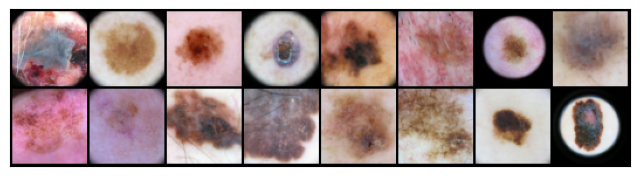

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 512

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([16, 3, 64, 64])


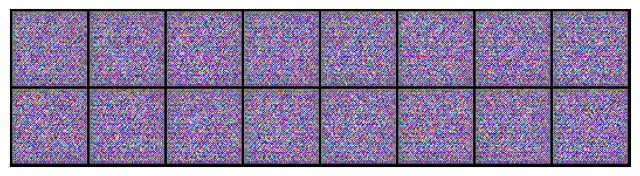

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated512latent_4'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True,save_size=(8,8)):
    fake_images = generator(latent_tensors)

    # Create a directory to save individual images if it doesn't exist
    os.makedirs(sample_dir, exist_ok=True)

    for i, fake_image in enumerate(fake_images):
        fake_fname = 'generated-image-{0:0=4d}-{1:0=2d}.png'.format(index, i)
        fake_image = fake_image.view(3, 64, 64)
        save_image(denorm(fake_image.unsqueeze(0)), os.path.join(sample_dir, fake_fname))
        print('Saving', fake_fname)

        if show:
            # Convert the tensor to numpy after detaching it
            plt.figure(figsize=(4, 4))
            plt.imshow(denorm(fake_image).permute(1, 2, 0).detach().cpu().numpy())
            plt.axis('off')
            plt.show()



In [ ]:
fixed_latent = torch.randn(5, latent_size, 1, 1, device=device)

Saving generated-image-0000-00.png


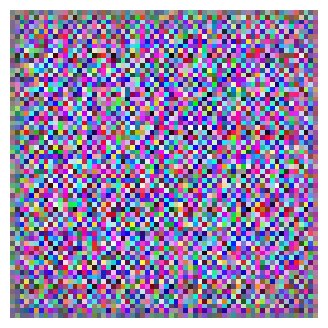

Saving generated-image-0000-01.png


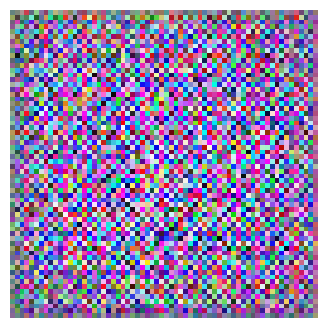

Saving generated-image-0000-02.png


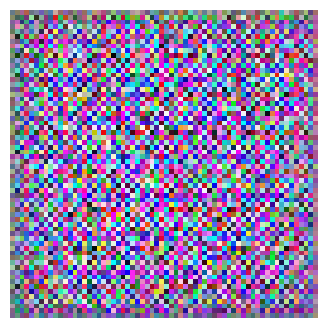

Saving generated-image-0000-03.png


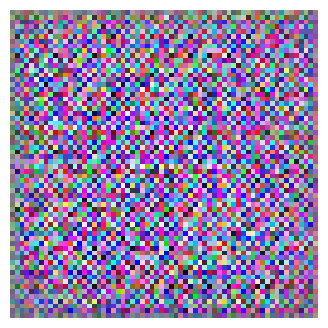

Saving generated-image-0000-04.png


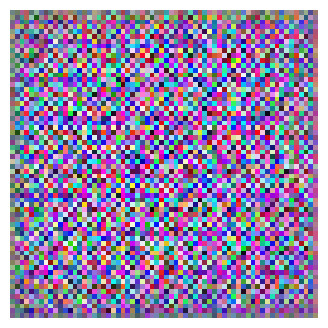

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        if epoch>=40:
          # Save generated images
           save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0001
epochs = 200

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [1/200], loss_g: 5.8512, loss_d: 0.0820, real_score: 0.9732, fake_score: 0.0520


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 5.6857, loss_d: 0.5302, real_score: 0.6957, fake_score: 0.0440


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 7.1476, loss_d: 0.0336, real_score: 0.9943, fake_score: 0.0275


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 6.5193, loss_d: 0.1046, real_score: 0.9203, fake_score: 0.0134


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 6.8870, loss_d: 0.0151, real_score: 0.9932, fake_score: 0.0081


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 2.9048, loss_d: 0.4847, real_score: 0.6836, fake_score: 0.0080


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 7.1828, loss_d: 0.3657, real_score: 0.8021, fake_score: 0.0105


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 3.6833, loss_d: 0.3294, real_score: 0.7961, fake_score: 0.0128


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 5.8270, loss_d: 0.0183, real_score: 0.9996, fake_score: 0.0177


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 7.6764, loss_d: 0.0131, real_score: 0.9963, fake_score: 0.0094


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 6.7387, loss_d: 0.0103, real_score: 0.9950, fake_score: 0.0052


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 6.6510, loss_d: 0.0241, real_score: 0.9812, fake_score: 0.0050


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 2.1965, loss_d: 0.2889, real_score: 0.8066, fake_score: 0.0067


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 7.4668, loss_d: 0.0234, real_score: 1.0000, fake_score: 0.0231


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 4.4889, loss_d: 0.4884, real_score: 0.6849, fake_score: 0.0112


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 7.4818, loss_d: 0.0009, real_score: 0.9997, fake_score: 0.0007


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 6.2237, loss_d: 0.0124, real_score: 0.9945, fake_score: 0.0068


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 2.0907, loss_d: 0.8208, real_score: 0.6880, fake_score: 0.0066


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 8.2844, loss_d: 0.0732, real_score: 0.9712, fake_score: 0.0408


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 5.0872, loss_d: 0.0095, real_score: 0.9984, fake_score: 0.0078


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 5.9746, loss_d: 0.0383, real_score: 0.9989, fake_score: 0.0363


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 7.3220, loss_d: 0.0630, real_score: 0.9992, fake_score: 0.0592


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 8.3798, loss_d: 0.0106, real_score: 0.9940, fake_score: 0.0046


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 3.3863, loss_d: 0.3168, real_score: 0.7974, fake_score: 0.0264


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 3.8689, loss_d: 0.0368, real_score: 0.9828, fake_score: 0.0186


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 5.5867, loss_d: 0.0258, real_score: 0.9945, fake_score: 0.0199


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 5.2897, loss_d: 0.1618, real_score: 0.9619, fake_score: 0.1086


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 0.9091, loss_d: 6.0066, real_score: 0.0051, fake_score: 0.0241


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 0.6133, loss_d: 0.9778, real_score: 0.4564, fake_score: 0.0345


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 6.4145, loss_d: 0.3677, real_score: 0.9870, fake_score: 0.2853


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 3.3456, loss_d: 0.5877, real_score: 0.6424, fake_score: 0.0443


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 3.0118, loss_d: 0.0543, real_score: 0.9776, fake_score: 0.0302


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 2.1470, loss_d: 0.3261, real_score: 0.7995, fake_score: 0.0515


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 1.8732, loss_d: 0.8075, real_score: 0.5548, fake_score: 0.0073


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 0.0858, loss_d: 1.4123, real_score: 0.3964, fake_score: 0.0195


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 6.0164, loss_d: 0.2325, real_score: 0.9976, fake_score: 0.1868


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 4.4713, loss_d: 0.1938, real_score: 0.9907, fake_score: 0.1460


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 0.9829, loss_d: 2.1902, real_score: 0.2609, fake_score: 0.0354


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 0.5357, loss_d: 0.8561, real_score: 0.5847, fake_score: 0.0817


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 3.7643, loss_d: 0.2577, real_score: 0.8814, fake_score: 0.1093


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 4.4394, loss_d: 0.1214, real_score: 0.9495, fake_score: 0.0636
Saving generated-image-0041-00.png
Saving generated-image-0041-01.png
Saving generated-image-0041-02.png
Saving generated-image-0041-03.png
Saving generated-image-0041-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 3.6603, loss_d: 0.2472, real_score: 0.9125, fake_score: 0.1016
Saving generated-image-0042-00.png
Saving generated-image-0042-01.png
Saving generated-image-0042-02.png
Saving generated-image-0042-03.png
Saving generated-image-0042-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 1.4697, loss_d: 0.6200, real_score: 0.6159, fake_score: 0.0320
Saving generated-image-0043-00.png
Saving generated-image-0043-01.png
Saving generated-image-0043-02.png
Saving generated-image-0043-03.png
Saving generated-image-0043-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 1.1877, loss_d: 0.9093, real_score: 0.5450, fake_score: 0.0106
Saving generated-image-0044-00.png
Saving generated-image-0044-01.png
Saving generated-image-0044-02.png
Saving generated-image-0044-03.png
Saving generated-image-0044-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 6.5492, loss_d: 0.1440, real_score: 0.8721, fake_score: 0.0036
Saving generated-image-0045-00.png
Saving generated-image-0045-01.png
Saving generated-image-0045-02.png
Saving generated-image-0045-03.png
Saving generated-image-0045-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 5.7229, loss_d: 0.0550, real_score: 0.9961, fake_score: 0.0472
Saving generated-image-0046-00.png
Saving generated-image-0046-01.png
Saving generated-image-0046-02.png
Saving generated-image-0046-03.png
Saving generated-image-0046-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 3.4637, loss_d: 0.2220, real_score: 0.8879, fake_score: 0.0913
Saving generated-image-0047-00.png
Saving generated-image-0047-01.png
Saving generated-image-0047-02.png
Saving generated-image-0047-03.png
Saving generated-image-0047-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 1.6327, loss_d: 1.9335, real_score: 0.2622, fake_score: 0.1177
Saving generated-image-0048-00.png
Saving generated-image-0048-01.png
Saving generated-image-0048-02.png
Saving generated-image-0048-03.png
Saving generated-image-0048-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 1.2121, loss_d: 2.1538, real_score: 0.1785, fake_score: 0.0226
Saving generated-image-0049-00.png
Saving generated-image-0049-01.png
Saving generated-image-0049-02.png
Saving generated-image-0049-03.png
Saving generated-image-0049-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 1.7488, loss_d: 1.5927, real_score: 0.2998, fake_score: 0.0362
Saving generated-image-0050-00.png
Saving generated-image-0050-01.png
Saving generated-image-0050-02.png
Saving generated-image-0050-03.png
Saving generated-image-0050-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 2.8109, loss_d: 0.1821, real_score: 0.9299, fake_score: 0.0990
Saving generated-image-0051-00.png
Saving generated-image-0051-01.png
Saving generated-image-0051-02.png
Saving generated-image-0051-03.png
Saving generated-image-0051-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 4.4090, loss_d: 0.1622, real_score: 0.9419, fake_score: 0.0887
Saving generated-image-0052-00.png
Saving generated-image-0052-01.png
Saving generated-image-0052-02.png
Saving generated-image-0052-03.png
Saving generated-image-0052-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 0.6797, loss_d: 0.4795, real_score: 0.6555, fake_score: 0.0204
Saving generated-image-0053-00.png
Saving generated-image-0053-01.png
Saving generated-image-0053-02.png
Saving generated-image-0053-03.png
Saving generated-image-0053-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 5.7264, loss_d: 0.6382, real_score: 0.9929, fake_score: 0.4252
Saving generated-image-0054-00.png
Saving generated-image-0054-01.png
Saving generated-image-0054-02.png
Saving generated-image-0054-03.png
Saving generated-image-0054-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 4.9666, loss_d: 0.6407, real_score: 0.9999, fake_score: 0.3805
Saving generated-image-0055-00.png
Saving generated-image-0055-01.png
Saving generated-image-0055-02.png
Saving generated-image-0055-03.png
Saving generated-image-0055-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 2.8545, loss_d: 0.9713, real_score: 0.5284, fake_score: 0.0136
Saving generated-image-0056-00.png
Saving generated-image-0056-01.png
Saving generated-image-0056-02.png
Saving generated-image-0056-03.png
Saving generated-image-0056-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 1.7198, loss_d: 0.8023, real_score: 0.5529, fake_score: 0.0232
Saving generated-image-0057-00.png
Saving generated-image-0057-01.png
Saving generated-image-0057-02.png
Saving generated-image-0057-03.png
Saving generated-image-0057-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 0.7537, loss_d: 2.2915, real_score: 0.1543, fake_score: 0.0023
Saving generated-image-0058-00.png
Saving generated-image-0058-01.png
Saving generated-image-0058-02.png
Saving generated-image-0058-03.png
Saving generated-image-0058-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 2.8207, loss_d: 0.8572, real_score: 0.5963, fake_score: 0.1518
Saving generated-image-0059-00.png
Saving generated-image-0059-01.png
Saving generated-image-0059-02.png
Saving generated-image-0059-03.png
Saving generated-image-0059-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 3.9123, loss_d: 0.1257, real_score: 0.9882, fake_score: 0.1015
Saving generated-image-0060-00.png
Saving generated-image-0060-01.png
Saving generated-image-0060-02.png
Saving generated-image-0060-03.png
Saving generated-image-0060-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 5.2981, loss_d: 0.0597, real_score: 0.9679, fake_score: 0.0260
Saving generated-image-0061-00.png
Saving generated-image-0061-01.png
Saving generated-image-0061-02.png
Saving generated-image-0061-03.png
Saving generated-image-0061-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 5.2960, loss_d: 0.2639, real_score: 0.9296, fake_score: 0.1605
Saving generated-image-0062-00.png
Saving generated-image-0062-01.png
Saving generated-image-0062-02.png
Saving generated-image-0062-03.png
Saving generated-image-0062-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 1.5332, loss_d: 1.3088, real_score: 0.3471, fake_score: 0.0093
Saving generated-image-0063-00.png
Saving generated-image-0063-01.png
Saving generated-image-0063-02.png
Saving generated-image-0063-03.png
Saving generated-image-0063-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 2.1530, loss_d: 0.8967, real_score: 0.4933, fake_score: 0.0185
Saving generated-image-0064-00.png
Saving generated-image-0064-01.png
Saving generated-image-0064-02.png
Saving generated-image-0064-03.png
Saving generated-image-0064-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 1.2257, loss_d: 0.3391, real_score: 0.8042, fake_score: 0.1001
Saving generated-image-0065-00.png
Saving generated-image-0065-01.png
Saving generated-image-0065-02.png
Saving generated-image-0065-03.png
Saving generated-image-0065-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 3.7108, loss_d: 0.4192, real_score: 0.8091, fake_score: 0.1382
Saving generated-image-0066-00.png
Saving generated-image-0066-01.png
Saving generated-image-0066-02.png
Saving generated-image-0066-03.png
Saving generated-image-0066-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 1.9681, loss_d: 0.3617, real_score: 0.8962, fake_score: 0.1912
Saving generated-image-0067-00.png
Saving generated-image-0067-01.png
Saving generated-image-0067-02.png
Saving generated-image-0067-03.png
Saving generated-image-0067-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 2.0887, loss_d: 1.2656, real_score: 0.3476, fake_score: 0.0664
Saving generated-image-0068-00.png
Saving generated-image-0068-01.png
Saving generated-image-0068-02.png
Saving generated-image-0068-03.png
Saving generated-image-0068-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 4.4025, loss_d: 0.0544, real_score: 0.9670, fake_score: 0.0200
Saving generated-image-0069-00.png
Saving generated-image-0069-01.png
Saving generated-image-0069-02.png
Saving generated-image-0069-03.png
Saving generated-image-0069-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 4.3628, loss_d: 0.2542, real_score: 0.9624, fake_score: 0.1786
Saving generated-image-0070-00.png
Saving generated-image-0070-01.png
Saving generated-image-0070-02.png
Saving generated-image-0070-03.png
Saving generated-image-0070-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 4.4734, loss_d: 0.3626, real_score: 0.9217, fake_score: 0.1990
Saving generated-image-0071-00.png
Saving generated-image-0071-01.png
Saving generated-image-0071-02.png
Saving generated-image-0071-03.png
Saving generated-image-0071-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 5.3816, loss_d: 0.5424, real_score: 0.8795, fake_score: 0.2765
Saving generated-image-0072-00.png
Saving generated-image-0072-01.png
Saving generated-image-0072-02.png
Saving generated-image-0072-03.png
Saving generated-image-0072-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 0.2142, loss_d: 0.9307, real_score: 0.4632, fake_score: 0.0132
Saving generated-image-0073-00.png
Saving generated-image-0073-01.png
Saving generated-image-0073-02.png
Saving generated-image-0073-03.png
Saving generated-image-0073-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 1.0083, loss_d: 3.0791, real_score: 0.1048, fake_score: 0.0561
Saving generated-image-0074-00.png
Saving generated-image-0074-01.png
Saving generated-image-0074-02.png
Saving generated-image-0074-03.png
Saving generated-image-0074-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 1.4932, loss_d: 0.6157, real_score: 0.6066, fake_score: 0.0667
Saving generated-image-0075-00.png
Saving generated-image-0075-01.png
Saving generated-image-0075-02.png
Saving generated-image-0075-03.png
Saving generated-image-0075-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 4.0915, loss_d: 0.1362, real_score: 0.9841, fake_score: 0.1051
Saving generated-image-0076-00.png
Saving generated-image-0076-01.png
Saving generated-image-0076-02.png
Saving generated-image-0076-03.png
Saving generated-image-0076-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 2.1750, loss_d: 0.1261, real_score: 0.9869, fake_score: 0.0978
Saving generated-image-0077-00.png
Saving generated-image-0077-01.png
Saving generated-image-0077-02.png
Saving generated-image-0077-03.png
Saving generated-image-0077-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 2.5012, loss_d: 0.3829, real_score: 0.9878, fake_score: 0.2703
Saving generated-image-0078-00.png
Saving generated-image-0078-01.png
Saving generated-image-0078-02.png
Saving generated-image-0078-03.png
Saving generated-image-0078-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 2.6362, loss_d: 0.6763, real_score: 0.6288, fake_score: 0.0889
Saving generated-image-0079-00.png
Saving generated-image-0079-01.png
Saving generated-image-0079-02.png
Saving generated-image-0079-03.png
Saving generated-image-0079-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 0.4376, loss_d: 1.7514, real_score: 0.2682, fake_score: 0.0605
Saving generated-image-0080-00.png
Saving generated-image-0080-01.png
Saving generated-image-0080-02.png
Saving generated-image-0080-03.png
Saving generated-image-0080-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 2.7155, loss_d: 0.3828, real_score: 0.8185, fake_score: 0.1553
Saving generated-image-0081-00.png
Saving generated-image-0081-01.png
Saving generated-image-0081-02.png
Saving generated-image-0081-03.png
Saving generated-image-0081-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 2.3995, loss_d: 0.1152, real_score: 0.9596, fake_score: 0.0688
Saving generated-image-0082-00.png
Saving generated-image-0082-01.png
Saving generated-image-0082-02.png
Saving generated-image-0082-03.png
Saving generated-image-0082-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 5.0290, loss_d: 0.0843, real_score: 0.9433, fake_score: 0.0245
Saving generated-image-0083-00.png
Saving generated-image-0083-01.png
Saving generated-image-0083-02.png
Saving generated-image-0083-03.png
Saving generated-image-0083-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 1.5012, loss_d: 2.1991, real_score: 0.2167, fake_score: 0.0899
Saving generated-image-0084-00.png
Saving generated-image-0084-01.png
Saving generated-image-0084-02.png
Saving generated-image-0084-03.png
Saving generated-image-0084-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 6.5185, loss_d: 0.2505, real_score: 0.7912, fake_score: 0.0016
Saving generated-image-0085-00.png
Saving generated-image-0085-01.png
Saving generated-image-0085-02.png
Saving generated-image-0085-03.png
Saving generated-image-0085-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 4.8091, loss_d: 1.3243, real_score: 0.9723, fake_score: 0.5814
Saving generated-image-0086-00.png
Saving generated-image-0086-01.png
Saving generated-image-0086-02.png
Saving generated-image-0086-03.png
Saving generated-image-0086-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 6.3059, loss_d: 0.3289, real_score: 0.9697, fake_score: 0.2447
Saving generated-image-0087-00.png
Saving generated-image-0087-01.png
Saving generated-image-0087-02.png
Saving generated-image-0087-03.png
Saving generated-image-0087-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [88/200], loss_g: 3.0441, loss_d: 0.0793, real_score: 0.9995, fake_score: 0.0730
Saving generated-image-0088-00.png
Saving generated-image-0088-01.png
Saving generated-image-0088-02.png
Saving generated-image-0088-03.png
Saving generated-image-0088-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 4.7360, loss_d: 1.0604, real_score: 0.4760, fake_score: 0.0107
Saving generated-image-0089-00.png
Saving generated-image-0089-01.png
Saving generated-image-0089-02.png
Saving generated-image-0089-03.png
Saving generated-image-0089-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 6.7050, loss_d: 0.7137, real_score: 0.8272, fake_score: 0.3552
Saving generated-image-0090-00.png
Saving generated-image-0090-01.png
Saving generated-image-0090-02.png
Saving generated-image-0090-03.png
Saving generated-image-0090-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 3.1833, loss_d: 0.2277, real_score: 0.8060, fake_score: 0.0098
Saving generated-image-0091-00.png
Saving generated-image-0091-01.png
Saving generated-image-0091-02.png
Saving generated-image-0091-03.png
Saving generated-image-0091-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 4.6962, loss_d: 0.2723, real_score: 0.7845, fake_score: 0.0010
Saving generated-image-0092-00.png
Saving generated-image-0092-01.png
Saving generated-image-0092-02.png
Saving generated-image-0092-03.png
Saving generated-image-0092-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 2.6499, loss_d: 0.5337, real_score: 0.6337, fake_score: 0.0249
Saving generated-image-0093-00.png
Saving generated-image-0093-01.png
Saving generated-image-0093-02.png
Saving generated-image-0093-03.png
Saving generated-image-0093-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 2.4849, loss_d: 0.3307, real_score: 0.7941, fake_score: 0.0722
Saving generated-image-0094-00.png
Saving generated-image-0094-01.png
Saving generated-image-0094-02.png
Saving generated-image-0094-03.png
Saving generated-image-0094-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 3.4513, loss_d: 0.2153, real_score: 0.8389, fake_score: 0.0311
Saving generated-image-0095-00.png
Saving generated-image-0095-01.png
Saving generated-image-0095-02.png
Saving generated-image-0095-03.png
Saving generated-image-0095-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 3.6127, loss_d: 0.3698, real_score: 0.7807, fake_score: 0.0903
Saving generated-image-0096-00.png
Saving generated-image-0096-01.png
Saving generated-image-0096-02.png
Saving generated-image-0096-03.png
Saving generated-image-0096-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 4.6401, loss_d: 0.0682, real_score: 0.9630, fake_score: 0.0295
Saving generated-image-0097-00.png
Saving generated-image-0097-01.png
Saving generated-image-0097-02.png
Saving generated-image-0097-03.png
Saving generated-image-0097-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 3.5381, loss_d: 0.2700, real_score: 0.7924, fake_score: 0.0088
Saving generated-image-0098-00.png
Saving generated-image-0098-01.png
Saving generated-image-0098-02.png
Saving generated-image-0098-03.png
Saving generated-image-0098-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 2.6367, loss_d: 0.5775, real_score: 0.7102, fake_score: 0.1225
Saving generated-image-0099-00.png
Saving generated-image-0099-01.png
Saving generated-image-0099-02.png
Saving generated-image-0099-03.png
Saving generated-image-0099-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 3.6764, loss_d: 0.1458, real_score: 0.9115, fake_score: 0.0485
Saving generated-image-0100-00.png
Saving generated-image-0100-01.png
Saving generated-image-0100-02.png
Saving generated-image-0100-03.png
Saving generated-image-0100-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 3.7055, loss_d: 0.3269, real_score: 0.9449, fake_score: 0.2165
Saving generated-image-0101-00.png
Saving generated-image-0101-01.png
Saving generated-image-0101-02.png
Saving generated-image-0101-03.png
Saving generated-image-0101-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [102/200], loss_g: 1.5224, loss_d: 0.8871, real_score: 0.4978, fake_score: 0.0059
Saving generated-image-0102-00.png
Saving generated-image-0102-01.png
Saving generated-image-0102-02.png
Saving generated-image-0102-03.png
Saving generated-image-0102-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 2.1066, loss_d: 0.9709, real_score: 0.7406, fake_score: 0.2264
Saving generated-image-0103-00.png
Saving generated-image-0103-01.png
Saving generated-image-0103-02.png
Saving generated-image-0103-03.png
Saving generated-image-0103-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [104/200], loss_g: 3.8799, loss_d: 0.0783, real_score: 0.9850, fake_score: 0.0603
Saving generated-image-0104-00.png
Saving generated-image-0104-01.png
Saving generated-image-0104-02.png
Saving generated-image-0104-03.png
Saving generated-image-0104-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 2.0698, loss_d: 0.2494, real_score: 0.8740, fake_score: 0.0965
Saving generated-image-0105-00.png
Saving generated-image-0105-01.png
Saving generated-image-0105-02.png
Saving generated-image-0105-03.png
Saving generated-image-0105-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [106/200], loss_g: 1.6150, loss_d: 2.7732, real_score: 0.0896, fake_score: 0.0209
Saving generated-image-0106-00.png
Saving generated-image-0106-01.png
Saving generated-image-0106-02.png
Saving generated-image-0106-03.png
Saving generated-image-0106-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 4.5119, loss_d: 0.4170, real_score: 0.7388, fake_score: 0.0393
Saving generated-image-0107-00.png
Saving generated-image-0107-01.png
Saving generated-image-0107-02.png
Saving generated-image-0107-03.png
Saving generated-image-0107-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 2.9298, loss_d: 0.2511, real_score: 0.9352, fake_score: 0.1552
Saving generated-image-0108-00.png
Saving generated-image-0108-01.png
Saving generated-image-0108-02.png
Saving generated-image-0108-03.png
Saving generated-image-0108-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [109/200], loss_g: 3.6520, loss_d: 0.1267, real_score: 0.9210, fake_score: 0.0402
Saving generated-image-0109-00.png
Saving generated-image-0109-01.png
Saving generated-image-0109-02.png
Saving generated-image-0109-03.png
Saving generated-image-0109-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 2.3463, loss_d: 0.1194, real_score: 0.9883, fake_score: 0.0957
Saving generated-image-0110-00.png
Saving generated-image-0110-01.png
Saving generated-image-0110-02.png
Saving generated-image-0110-03.png
Saving generated-image-0110-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [111/200], loss_g: 0.3245, loss_d: 0.9657, real_score: 0.4461, fake_score: 0.0846
Saving generated-image-0111-00.png
Saving generated-image-0111-01.png
Saving generated-image-0111-02.png
Saving generated-image-0111-03.png
Saving generated-image-0111-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 2.6744, loss_d: 0.5543, real_score: 0.6821, fake_score: 0.0902
Saving generated-image-0112-00.png
Saving generated-image-0112-01.png
Saving generated-image-0112-02.png
Saving generated-image-0112-03.png
Saving generated-image-0112-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 2.9200, loss_d: 0.2695, real_score: 0.9987, fake_score: 0.2200
Saving generated-image-0113-00.png
Saving generated-image-0113-01.png
Saving generated-image-0113-02.png
Saving generated-image-0113-03.png
Saving generated-image-0113-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [114/200], loss_g: 3.6354, loss_d: 2.1206, real_score: 0.3060, fake_score: 0.0015
Saving generated-image-0114-00.png
Saving generated-image-0114-01.png
Saving generated-image-0114-02.png
Saving generated-image-0114-03.png
Saving generated-image-0114-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 3.6847, loss_d: 0.2955, real_score: 0.9030, fake_score: 0.1508
Saving generated-image-0115-00.png
Saving generated-image-0115-01.png
Saving generated-image-0115-02.png
Saving generated-image-0115-03.png
Saving generated-image-0115-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 3.3181, loss_d: 0.2123, real_score: 0.9990, fake_score: 0.1476
Saving generated-image-0116-00.png
Saving generated-image-0116-01.png
Saving generated-image-0116-02.png
Saving generated-image-0116-03.png
Saving generated-image-0116-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [117/200], loss_g: 5.6520, loss_d: 0.2452, real_score: 0.9734, fake_score: 0.1699
Saving generated-image-0117-00.png
Saving generated-image-0117-01.png
Saving generated-image-0117-02.png
Saving generated-image-0117-03.png
Saving generated-image-0117-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 3.4392, loss_d: 0.0215, real_score: 0.9830, fake_score: 0.0043
Saving generated-image-0118-00.png
Saving generated-image-0118-01.png
Saving generated-image-0118-02.png
Saving generated-image-0118-03.png
Saving generated-image-0118-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 3.2668, loss_d: 0.2842, real_score: 0.8020, fake_score: 0.0258
Saving generated-image-0119-00.png
Saving generated-image-0119-01.png
Saving generated-image-0119-02.png
Saving generated-image-0119-03.png
Saving generated-image-0119-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 6.5880, loss_d: 0.3706, real_score: 0.8510, fake_score: 0.1417
Saving generated-image-0120-00.png
Saving generated-image-0120-01.png
Saving generated-image-0120-02.png
Saving generated-image-0120-03.png
Saving generated-image-0120-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 1.7425, loss_d: 0.2581, real_score: 0.8191, fake_score: 0.0311
Saving generated-image-0121-00.png
Saving generated-image-0121-01.png
Saving generated-image-0121-02.png
Saving generated-image-0121-03.png
Saving generated-image-0121-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [122/200], loss_g: 2.9298, loss_d: 0.4136, real_score: 0.7487, fake_score: 0.0845
Saving generated-image-0122-00.png
Saving generated-image-0122-01.png
Saving generated-image-0122-02.png
Saving generated-image-0122-03.png
Saving generated-image-0122-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 2.8082, loss_d: 0.2672, real_score: 0.8527, fake_score: 0.0806
Saving generated-image-0123-00.png
Saving generated-image-0123-01.png
Saving generated-image-0123-02.png
Saving generated-image-0123-03.png
Saving generated-image-0123-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 4.7229, loss_d: 0.7264, real_score: 0.7010, fake_score: 0.1914
Saving generated-image-0124-00.png
Saving generated-image-0124-01.png
Saving generated-image-0124-02.png
Saving generated-image-0124-03.png
Saving generated-image-0124-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [125/200], loss_g: 4.7034, loss_d: 0.1050, real_score: 0.9523, fake_score: 0.0471
Saving generated-image-0125-00.png
Saving generated-image-0125-01.png
Saving generated-image-0125-02.png
Saving generated-image-0125-03.png
Saving generated-image-0125-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 3.8071, loss_d: 0.1420, real_score: 0.9670, fake_score: 0.0990
Saving generated-image-0126-00.png
Saving generated-image-0126-01.png
Saving generated-image-0126-02.png
Saving generated-image-0126-03.png
Saving generated-image-0126-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 1.7248, loss_d: 0.1515, real_score: 0.9948, fake_score: 0.1150
Saving generated-image-0127-00.png
Saving generated-image-0127-01.png
Saving generated-image-0127-02.png
Saving generated-image-0127-03.png
Saving generated-image-0127-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [128/200], loss_g: 4.9270, loss_d: 0.8075, real_score: 0.9994, fake_score: 0.4692
Saving generated-image-0128-00.png
Saving generated-image-0128-01.png
Saving generated-image-0128-02.png
Saving generated-image-0128-03.png
Saving generated-image-0128-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 2.2280, loss_d: 0.0450, real_score: 0.9938, fake_score: 0.0366
Saving generated-image-0129-00.png
Saving generated-image-0129-01.png
Saving generated-image-0129-02.png
Saving generated-image-0129-03.png
Saving generated-image-0129-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 3.1228, loss_d: 0.1020, real_score: 0.9775, fake_score: 0.0713
Saving generated-image-0130-00.png
Saving generated-image-0130-01.png
Saving generated-image-0130-02.png
Saving generated-image-0130-03.png
Saving generated-image-0130-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 3.4817, loss_d: 0.3104, real_score: 0.8472, fake_score: 0.1125
Saving generated-image-0131-00.png
Saving generated-image-0131-01.png
Saving generated-image-0131-02.png
Saving generated-image-0131-03.png
Saving generated-image-0131-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 3.1363, loss_d: 0.1026, real_score: 0.9944, fake_score: 0.0893
Saving generated-image-0132-00.png
Saving generated-image-0132-01.png
Saving generated-image-0132-02.png
Saving generated-image-0132-03.png
Saving generated-image-0132-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 2.0755, loss_d: 0.2329, real_score: 0.8395, fake_score: 0.0467
Saving generated-image-0133-00.png
Saving generated-image-0133-01.png
Saving generated-image-0133-02.png
Saving generated-image-0133-03.png
Saving generated-image-0133-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 8.2945, loss_d: 1.0178, real_score: 0.9695, fake_score: 0.4203
Saving generated-image-0134-00.png
Saving generated-image-0134-01.png
Saving generated-image-0134-02.png
Saving generated-image-0134-03.png
Saving generated-image-0134-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [135/200], loss_g: 3.5632, loss_d: 0.6101, real_score: 0.5704, fake_score: 0.0060
Saving generated-image-0135-00.png
Saving generated-image-0135-01.png
Saving generated-image-0135-02.png
Saving generated-image-0135-03.png
Saving generated-image-0135-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 1.7209, loss_d: 0.4349, real_score: 0.6736, fake_score: 0.0168
Saving generated-image-0136-00.png
Saving generated-image-0136-01.png
Saving generated-image-0136-02.png
Saving generated-image-0136-03.png
Saving generated-image-0136-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [137/200], loss_g: 4.6757, loss_d: 0.0751, real_score: 0.9594, fake_score: 0.0320
Saving generated-image-0137-00.png
Saving generated-image-0137-01.png
Saving generated-image-0137-02.png
Saving generated-image-0137-03.png
Saving generated-image-0137-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [138/200], loss_g: 3.5344, loss_d: 0.3706, real_score: 0.7645, fake_score: 0.0381
Saving generated-image-0138-00.png
Saving generated-image-0138-01.png
Saving generated-image-0138-02.png
Saving generated-image-0138-03.png
Saving generated-image-0138-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 3.3259, loss_d: 0.3792, real_score: 0.7016, fake_score: 0.0235
Saving generated-image-0139-00.png
Saving generated-image-0139-01.png
Saving generated-image-0139-02.png
Saving generated-image-0139-03.png
Saving generated-image-0139-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 3.3714, loss_d: 0.1124, real_score: 0.9087, fake_score: 0.0127
Saving generated-image-0140-00.png
Saving generated-image-0140-01.png
Saving generated-image-0140-02.png
Saving generated-image-0140-03.png
Saving generated-image-0140-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [141/200], loss_g: 4.7279, loss_d: 0.0699, real_score: 0.9535, fake_score: 0.0191
Saving generated-image-0141-00.png
Saving generated-image-0141-01.png
Saving generated-image-0141-02.png
Saving generated-image-0141-03.png
Saving generated-image-0141-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [142/200], loss_g: 4.3528, loss_d: 0.1285, real_score: 0.9677, fake_score: 0.0862
Saving generated-image-0142-00.png
Saving generated-image-0142-01.png
Saving generated-image-0142-02.png
Saving generated-image-0142-03.png
Saving generated-image-0142-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 5.7019, loss_d: 0.1482, real_score: 0.9955, fake_score: 0.1237
Saving generated-image-0143-00.png
Saving generated-image-0143-01.png
Saving generated-image-0143-02.png
Saving generated-image-0143-03.png
Saving generated-image-0143-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [144/200], loss_g: 5.1822, loss_d: 0.1925, real_score: 0.9979, fake_score: 0.1423
Saving generated-image-0144-00.png
Saving generated-image-0144-01.png
Saving generated-image-0144-02.png
Saving generated-image-0144-03.png
Saving generated-image-0144-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [145/200], loss_g: 4.1041, loss_d: 0.0659, real_score: 0.9644, fake_score: 0.0284
Saving generated-image-0145-00.png
Saving generated-image-0145-01.png
Saving generated-image-0145-02.png
Saving generated-image-0145-03.png
Saving generated-image-0145-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [146/200], loss_g: 5.6123, loss_d: 0.3604, real_score: 0.9464, fake_score: 0.2292
Saving generated-image-0146-00.png
Saving generated-image-0146-01.png
Saving generated-image-0146-02.png
Saving generated-image-0146-03.png
Saving generated-image-0146-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 2.0830, loss_d: 0.2205, real_score: 0.9193, fake_score: 0.1074
Saving generated-image-0147-00.png
Saving generated-image-0147-01.png
Saving generated-image-0147-02.png
Saving generated-image-0147-03.png
Saving generated-image-0147-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 3.9896, loss_d: 0.2958, real_score: 0.8786, fake_score: 0.1313
Saving generated-image-0148-00.png
Saving generated-image-0148-01.png
Saving generated-image-0148-02.png
Saving generated-image-0148-03.png
Saving generated-image-0148-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 3.0276, loss_d: 0.3325, real_score: 0.8032, fake_score: 0.0273
Saving generated-image-0149-00.png
Saving generated-image-0149-01.png
Saving generated-image-0149-02.png
Saving generated-image-0149-03.png
Saving generated-image-0149-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 3.9560, loss_d: 0.1568, real_score: 0.9026, fake_score: 0.0449
Saving generated-image-0150-00.png
Saving generated-image-0150-01.png
Saving generated-image-0150-02.png
Saving generated-image-0150-03.png
Saving generated-image-0150-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 3.8485, loss_d: 0.0560, real_score: 0.9767, fake_score: 0.0312
Saving generated-image-0151-00.png
Saving generated-image-0151-01.png
Saving generated-image-0151-02.png
Saving generated-image-0151-03.png
Saving generated-image-0151-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [152/200], loss_g: 4.1389, loss_d: 0.8633, real_score: 0.5847, fake_score: 0.1906
Saving generated-image-0152-00.png
Saving generated-image-0152-01.png
Saving generated-image-0152-02.png
Saving generated-image-0152-03.png
Saving generated-image-0152-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 4.3399, loss_d: 0.3711, real_score: 0.9987, fake_score: 0.2515
Saving generated-image-0153-00.png
Saving generated-image-0153-01.png
Saving generated-image-0153-02.png
Saving generated-image-0153-03.png
Saving generated-image-0153-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [154/200], loss_g: 4.3608, loss_d: 0.2149, real_score: 0.9076, fake_score: 0.0882
Saving generated-image-0154-00.png
Saving generated-image-0154-01.png
Saving generated-image-0154-02.png
Saving generated-image-0154-03.png
Saving generated-image-0154-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [155/200], loss_g: 4.8483, loss_d: 0.0229, real_score: 0.9807, fake_score: 0.0030
Saving generated-image-0155-00.png
Saving generated-image-0155-01.png
Saving generated-image-0155-02.png
Saving generated-image-0155-03.png
Saving generated-image-0155-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 3.5483, loss_d: 0.1329, real_score: 0.9945, fake_score: 0.1111
Saving generated-image-0156-00.png
Saving generated-image-0156-01.png
Saving generated-image-0156-02.png
Saving generated-image-0156-03.png
Saving generated-image-0156-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [157/200], loss_g: 1.3759, loss_d: 0.3140, real_score: 0.7772, fake_score: 0.0362
Saving generated-image-0157-00.png
Saving generated-image-0157-01.png
Saving generated-image-0157-02.png
Saving generated-image-0157-03.png
Saving generated-image-0157-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 4.2338, loss_d: 0.0366, real_score: 0.9972, fake_score: 0.0322
Saving generated-image-0158-00.png
Saving generated-image-0158-01.png
Saving generated-image-0158-02.png
Saving generated-image-0158-03.png
Saving generated-image-0158-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [159/200], loss_g: 5.5243, loss_d: 0.0634, real_score: 0.9996, fake_score: 0.0585
Saving generated-image-0159-00.png
Saving generated-image-0159-01.png
Saving generated-image-0159-02.png
Saving generated-image-0159-03.png
Saving generated-image-0159-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 4.1027, loss_d: 0.0681, real_score: 0.9755, fake_score: 0.0415
Saving generated-image-0160-00.png
Saving generated-image-0160-01.png
Saving generated-image-0160-02.png
Saving generated-image-0160-03.png
Saving generated-image-0160-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 3.5460, loss_d: 0.0966, real_score: 0.9613, fake_score: 0.0460
Saving generated-image-0161-00.png
Saving generated-image-0161-01.png
Saving generated-image-0161-02.png
Saving generated-image-0161-03.png
Saving generated-image-0161-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 3.6882, loss_d: 0.0563, real_score: 0.9736, fake_score: 0.0278
Saving generated-image-0162-00.png
Saving generated-image-0162-01.png
Saving generated-image-0162-02.png
Saving generated-image-0162-03.png
Saving generated-image-0162-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 4.4996, loss_d: 0.4775, real_score: 0.6654, fake_score: 0.0107
Saving generated-image-0163-00.png
Saving generated-image-0163-01.png
Saving generated-image-0163-02.png
Saving generated-image-0163-03.png
Saving generated-image-0163-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [164/200], loss_g: 4.7927, loss_d: 0.0663, real_score: 0.9848, fake_score: 0.0472
Saving generated-image-0164-00.png
Saving generated-image-0164-01.png
Saving generated-image-0164-02.png
Saving generated-image-0164-03.png
Saving generated-image-0164-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 3.6037, loss_d: 0.2096, real_score: 0.8336, fake_score: 0.0093
Saving generated-image-0165-00.png
Saving generated-image-0165-01.png
Saving generated-image-0165-02.png
Saving generated-image-0165-03.png
Saving generated-image-0165-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 6.0209, loss_d: 0.4954, real_score: 0.7666, fake_score: 0.1082
Saving generated-image-0166-00.png
Saving generated-image-0166-01.png
Saving generated-image-0166-02.png
Saving generated-image-0166-03.png
Saving generated-image-0166-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [167/200], loss_g: 5.4787, loss_d: 0.1279, real_score: 0.9198, fake_score: 0.0402
Saving generated-image-0167-00.png
Saving generated-image-0167-01.png
Saving generated-image-0167-02.png
Saving generated-image-0167-03.png
Saving generated-image-0167-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 4.8389, loss_d: 0.1863, real_score: 0.9843, fake_score: 0.1204
Saving generated-image-0168-00.png
Saving generated-image-0168-01.png
Saving generated-image-0168-02.png
Saving generated-image-0168-03.png
Saving generated-image-0168-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [169/200], loss_g: 5.6849, loss_d: 0.1515, real_score: 0.8977, fake_score: 0.0387
Saving generated-image-0169-00.png
Saving generated-image-0169-01.png
Saving generated-image-0169-02.png
Saving generated-image-0169-03.png
Saving generated-image-0169-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 3.6413, loss_d: 1.3377, real_score: 0.4045, fake_score: 0.0023
Saving generated-image-0170-00.png
Saving generated-image-0170-01.png
Saving generated-image-0170-02.png
Saving generated-image-0170-03.png
Saving generated-image-0170-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 2.8378, loss_d: 0.0681, real_score: 0.9781, fake_score: 0.0428
Saving generated-image-0171-00.png
Saving generated-image-0171-01.png
Saving generated-image-0171-02.png
Saving generated-image-0171-03.png
Saving generated-image-0171-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 6.1085, loss_d: 0.1992, real_score: 0.9853, fake_score: 0.1493
Saving generated-image-0172-00.png
Saving generated-image-0172-01.png
Saving generated-image-0172-02.png
Saving generated-image-0172-03.png
Saving generated-image-0172-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [173/200], loss_g: 5.0034, loss_d: 0.1468, real_score: 0.9135, fake_score: 0.0500
Saving generated-image-0173-00.png
Saving generated-image-0173-01.png
Saving generated-image-0173-02.png
Saving generated-image-0173-03.png
Saving generated-image-0173-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 3.1878, loss_d: 0.0890, real_score: 0.9246, fake_score: 0.0089
Saving generated-image-0174-00.png
Saving generated-image-0174-01.png
Saving generated-image-0174-02.png
Saving generated-image-0174-03.png
Saving generated-image-0174-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [175/200], loss_g: 3.6711, loss_d: 0.0897, real_score: 0.9789, fake_score: 0.0642
Saving generated-image-0175-00.png
Saving generated-image-0175-01.png
Saving generated-image-0175-02.png
Saving generated-image-0175-03.png
Saving generated-image-0175-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 4.0133, loss_d: 0.0344, real_score: 0.9913, fake_score: 0.0249
Saving generated-image-0176-00.png
Saving generated-image-0176-01.png
Saving generated-image-0176-02.png
Saving generated-image-0176-03.png
Saving generated-image-0176-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 5.8114, loss_d: 0.0251, real_score: 0.9961, fake_score: 0.0194
Saving generated-image-0177-00.png
Saving generated-image-0177-01.png
Saving generated-image-0177-02.png
Saving generated-image-0177-03.png
Saving generated-image-0177-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [178/200], loss_g: 4.8442, loss_d: 0.2133, real_score: 0.9790, fake_score: 0.1572
Saving generated-image-0178-00.png
Saving generated-image-0178-01.png
Saving generated-image-0178-02.png
Saving generated-image-0178-03.png
Saving generated-image-0178-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 2.8503, loss_d: 0.1328, real_score: 0.9026, fake_score: 0.0208
Saving generated-image-0179-00.png
Saving generated-image-0179-01.png
Saving generated-image-0179-02.png
Saving generated-image-0179-03.png
Saving generated-image-0179-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 6.7434, loss_d: 0.0217, real_score: 0.9836, fake_score: 0.0049
Saving generated-image-0180-00.png
Saving generated-image-0180-01.png
Saving generated-image-0180-02.png
Saving generated-image-0180-03.png
Saving generated-image-0180-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [181/200], loss_g: 6.6806, loss_d: 0.0287, real_score: 0.9837, fake_score: 0.0120
Saving generated-image-0181-00.png
Saving generated-image-0181-01.png
Saving generated-image-0181-02.png
Saving generated-image-0181-03.png
Saving generated-image-0181-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 5.5654, loss_d: 0.0119, real_score: 0.9943, fake_score: 0.0062
Saving generated-image-0182-00.png
Saving generated-image-0182-01.png
Saving generated-image-0182-02.png
Saving generated-image-0182-03.png
Saving generated-image-0182-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [183/200], loss_g: 4.8061, loss_d: 0.3944, real_score: 0.7754, fake_score: 0.0410
Saving generated-image-0183-00.png
Saving generated-image-0183-01.png
Saving generated-image-0183-02.png
Saving generated-image-0183-03.png
Saving generated-image-0183-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 8.1268, loss_d: 0.3739, real_score: 0.9791, fake_score: 0.1366
Saving generated-image-0184-00.png
Saving generated-image-0184-01.png
Saving generated-image-0184-02.png
Saving generated-image-0184-03.png
Saving generated-image-0184-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 3.6606, loss_d: 0.2061, real_score: 0.8590, fake_score: 0.0429
Saving generated-image-0185-00.png
Saving generated-image-0185-01.png
Saving generated-image-0185-02.png
Saving generated-image-0185-03.png
Saving generated-image-0185-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 1.4458, loss_d: 0.7921, real_score: 0.5185, fake_score: 0.0095
Saving generated-image-0186-00.png
Saving generated-image-0186-01.png
Saving generated-image-0186-02.png
Saving generated-image-0186-03.png
Saving generated-image-0186-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [187/200], loss_g: 4.0332, loss_d: 0.1347, real_score: 0.9902, fake_score: 0.1020
Saving generated-image-0187-00.png
Saving generated-image-0187-01.png
Saving generated-image-0187-02.png
Saving generated-image-0187-03.png
Saving generated-image-0187-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [188/200], loss_g: 7.9662, loss_d: 0.3437, real_score: 0.7813, fake_score: 0.0014
Saving generated-image-0188-00.png
Saving generated-image-0188-01.png
Saving generated-image-0188-02.png
Saving generated-image-0188-03.png
Saving generated-image-0188-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 5.6909, loss_d: 0.0577, real_score: 0.9586, fake_score: 0.0144
Saving generated-image-0189-00.png
Saving generated-image-0189-01.png
Saving generated-image-0189-02.png
Saving generated-image-0189-03.png
Saving generated-image-0189-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [190/200], loss_g: 6.7183, loss_d: 0.0351, real_score: 0.9748, fake_score: 0.0092
Saving generated-image-0190-00.png
Saving generated-image-0190-01.png
Saving generated-image-0190-02.png
Saving generated-image-0190-03.png
Saving generated-image-0190-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 5.4504, loss_d: 0.0901, real_score: 0.9304, fake_score: 0.0134
Saving generated-image-0191-00.png
Saving generated-image-0191-01.png
Saving generated-image-0191-02.png
Saving generated-image-0191-03.png
Saving generated-image-0191-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 3.4613, loss_d: 0.0664, real_score: 0.9799, fake_score: 0.0417
Saving generated-image-0192-00.png
Saving generated-image-0192-01.png
Saving generated-image-0192-02.png
Saving generated-image-0192-03.png
Saving generated-image-0192-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 3.7983, loss_d: 0.0117, real_score: 0.9944, fake_score: 0.0060
Saving generated-image-0193-00.png
Saving generated-image-0193-01.png
Saving generated-image-0193-02.png
Saving generated-image-0193-03.png
Saving generated-image-0193-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 2.6686, loss_d: 0.2529, real_score: 0.8261, fake_score: 0.0473
Saving generated-image-0194-00.png
Saving generated-image-0194-01.png
Saving generated-image-0194-02.png
Saving generated-image-0194-03.png
Saving generated-image-0194-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 7.5207, loss_d: 0.0925, real_score: 0.9287, fake_score: 0.0149
Saving generated-image-0195-00.png
Saving generated-image-0195-01.png
Saving generated-image-0195-02.png
Saving generated-image-0195-03.png
Saving generated-image-0195-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 5.9768, loss_d: 0.0696, real_score: 0.9823, fake_score: 0.0490
Saving generated-image-0196-00.png
Saving generated-image-0196-01.png
Saving generated-image-0196-02.png
Saving generated-image-0196-03.png
Saving generated-image-0196-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [197/200], loss_g: 3.0606, loss_d: 0.0994, real_score: 0.9257, fake_score: 0.0211
Saving generated-image-0197-00.png
Saving generated-image-0197-01.png
Saving generated-image-0197-02.png
Saving generated-image-0197-03.png
Saving generated-image-0197-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 6.3198, loss_d: 0.0780, real_score: 0.9568, fake_score: 0.0316
Saving generated-image-0198-00.png
Saving generated-image-0198-01.png
Saving generated-image-0198-02.png
Saving generated-image-0198-03.png
Saving generated-image-0198-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [199/200], loss_g: 4.3653, loss_d: 0.0980, real_score: 0.9290, fake_score: 0.0211
Saving generated-image-0199-00.png
Saving generated-image-0199-01.png
Saving generated-image-0199-02.png
Saving generated-image-0199-03.png
Saving generated-image-0199-04.png


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [200/200], loss_g: 3.3833, loss_d: 0.1308, real_score: 0.8995, fake_score: 0.0130
Saving generated-image-0200-00.png
Saving generated-image-0200-01.png
Saving generated-image-0200-02.png
Saving generated-image-0200-03.png
Saving generated-image-0200-04.png


In [ ]:
import shutil

# Define source and destination paths
source_folder = "generated512latent_4"
destination_folder = "/content/drive/My Drive/gan_imagesfinal_4        "

# Copy folder to Google Drive
shutil.copytree(source_folder, destination_folder)


'/content/drive/My Drive/gan_imagesfinal_4        '